<a href="https://colab.research.google.com/github/ykitaguchi77/YOLOv5/blob/main/YOLOv5_helmet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#ヘルメット画像の検出
#https://qiita.com/DS27/items/6ae8c49569c1a55a0255

import torch
from IPython.display import Image, clear_output
import os
import shutil

!git clone https://github.com/ultralytics/yolov5
os.chdir("/content/yolov5")
%pip install -qr requirements.txt



clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

# Setup complete. Using torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)

Setup complete. Using torch 1.12.1+cu113 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


detect: weights=['yolov5s.pt'], source=data/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-198-gacff977 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

100% 14.1M/14.1M [00:00<00:00, 226MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/2 /content/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, 17.1ms
image 2/2 /content/yolov5/data/images/zidane.jpg: 384x640 2 persons, 2 ties, 14.1ms
Speed: 0.5ms pre-process, 15.6ms inference, 19.5ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


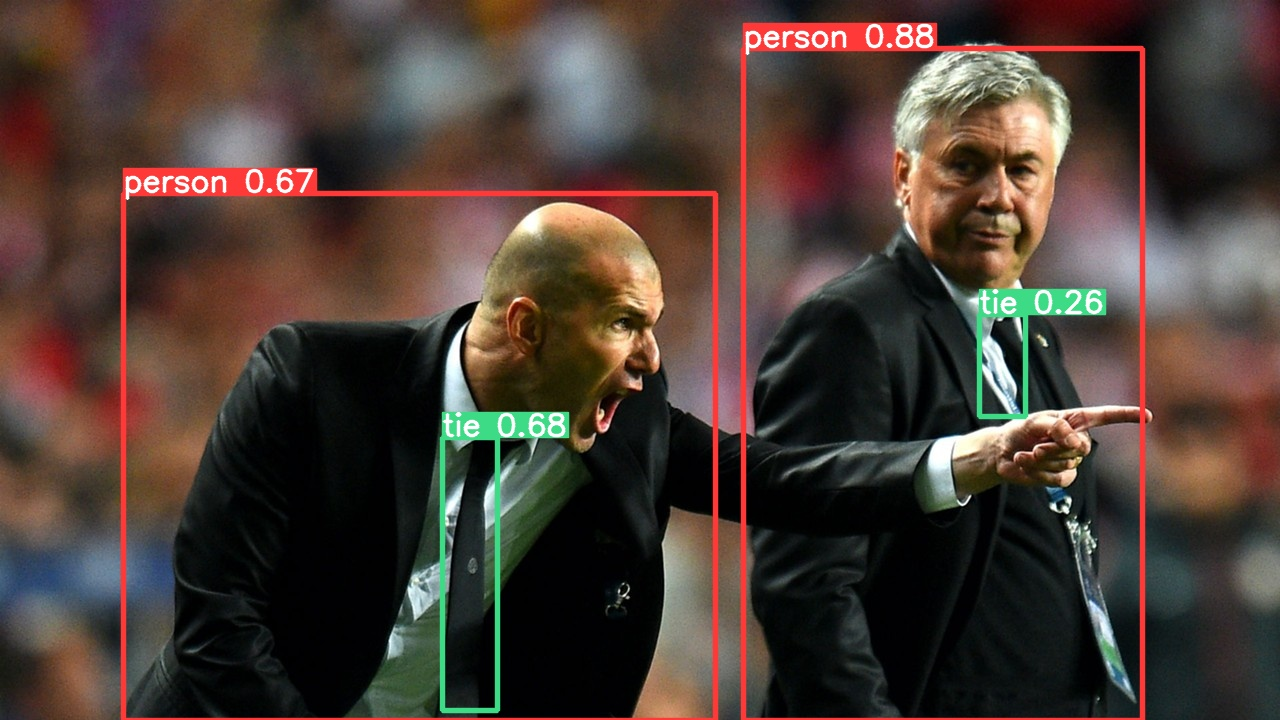

In [2]:
#動作確認
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images/
Image(filename='runs/detect/exp/zidane.jpg', width=600)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

#Hard_Hat_Workers（オープンデータセット）をcontentsフォルダにコピーしてyolov5内に展開する
shutil.copy("/content/drive/MyDrive/Deep_learning/YOLOv5/Hard_Hat_Workers.v2-raw.yolov5pytorch.zip", "/content/Workers.zip")
!unzip /content/Workers.zip 
!rm /content/Workers.zip

!ls /content/yolov5

ストリーミング出力は最後の 5000 行に切り捨てられました。
 extracting: train/labels/004879_jpg.rf.0d5c27700ff04fb911be2cc0b0ae7e44.txt  
 extracting: train/labels/000307_jpg.rf.0da33908e280d7c9d61d7cb6470ecd3f.txt  
 extracting: train/labels/005099_jpg.rf.0de8be5e21e09352a246b6c1faf53ecc.txt  
 extracting: train/labels/004482_jpg.rf.0d541b29bd4b4ededc19b5cafebb4fe9.txt  
 extracting: train/labels/000735_jpg.rf.0d5b96188e544511c13ac1e1bfff0b87.txt  
 extracting: train/labels/001653_jpg.rf.0cc3a72fd244aa7aadee6c4d766190df.txt  
 extracting: train/labels/002922_jpg.rf.0d24f020d6f688f966ef38c7a0eeba3e.txt  
 extracting: train/labels/004334_jpg.rf.0c7c46e2c74725ad2f93e916dc2422dd.txt  
 extracting: train/labels/002574_jpg.rf.0da9a892cf793903da78d6440b58779b.txt  
 extracting: train/labels/002336_jpg.rf.0ca4ec6f6ebaabe8df1781814ea731d9.txt  
 extracting: train/labels/001254_jpg.rf.0cb559668c7f79bc74c9f6b1a276d90d.txt  
 extracting: train/labels/004239_jpg.rf.0da69bb76e5393015f1e10528419a3fd.txt  
 extracting: train/l

# Yamlファイルのパスを修正

In [5]:
#内容を確認
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 3
names: ['head', 'helmet', 'person']

In [6]:
# define number of classes based on YAML
# data.yaml contains the information about number of classes and their labels required for this project
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])
    print(num_classes)

3


In [7]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [8]:
# Below we are changing the data configuration for right path to the dataset
# yamlファイルの書き換え（パスの修正）
%%writetemplate /content/yolov5/data.yaml

train: ./train/images
val: ./test/images

nc: 3
names: ['head', 'helmet', 'person']

In [9]:
with open(r'data.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    
    # yamlファイル全体の情報を取得
    labels_list = yaml.load(file, Loader=yaml.FullLoader)

    #yamlからラベル情報を抜き出し
    label_names = labels_list['names']

print("Number of Classes are {}, whose labels are {} for this Object Detection project".format(num_classes,label_names))

# Number of Classes are 3, whose labels are ['head', 'helmet', 'person'] for this Object Detection project
print("")
print(labels_list)
print(label_names)

Number of Classes are 3, whose labels are ['head', 'helmet', 'person'] for this Object Detection project

{'train': './train/images', 'val': './test/images', 'nc': 3, 'names': ['head', 'helmet', 'person']}
['head', 'helmet', 'person']


#yolo5s.yamlも修正する

In [10]:
# this is the model configuration we will use for our tutorial 
# yolov5s.yaml contains the configuration of neural network required for training.
# モデルの構成を確認
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [11]:
# Below we are changing the configuration so that it becomes compatible to number of classes required in this project
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes  # CHANGED HERE
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

#**モデルを学習**

In [ ]:
%%time
%cd /content/yolov5/

/content
CPU times: user 1.2 ms, sys: 38 µs, total: 1.24 ms
Wall time: 989 µs


In [ ]:
os.listdir("/content/yolov5/runs/train")

['exp', 'exp2']

In [ ]:
weight_path = "/content/yolov5/runs/train/exp"+str(np.amax(np.array([int(i.replace("exp", "0")) for i in os.listdir("/content/yolov5/runs/train") if "exp" in i])))+"/weights/best.pt"
weight_path

'/content/yolov5/runs/train/exp3/weights/best.pt'

In [ ]:
save_best_weight()

FileNotFoundError: ignored

In [ ]:
import numpy as np

# Training
# 10epochごとにベストモデルを退避させる

#数字の一番大きいexpフォルダを探し、そのフォルダのbest.ptをdrive上にコピー
def save_best_weight():
    weight_path = "/content/yolov5/runs/train/exp"+str(np.amax(np.array([int(i.replace("exp", "0")) for i in os.listdir("/content/yolov5/runs/train") if "exp" in i])))+"/weights/best.pt"
    shutil.copy(weight_path, "/content/drive/MyDrive/Deep_learning/YOLOv5/helmet.pt")


!python train.py --img 416 --batch 80 --epochs 10 --data './data.yaml' --cfg ./models/custom_yolov5s.yaml --weights /content/yolov5/yolov5s.pt
save_best_weight()
print("10 epochs done!")


!python train.py --img 416 --batch 80 --resume --epochs 10 --data './data.yaml' --cfg ./models/custom_yolov5s.yaml --weights /content/drive/MyDrive/Deep_learning/YOLOv5/helmet.pt
save_best_weight()
print("20 epochs done!")

!python train.py --img 416 --batch 80 --resume --epochs 10 --data './data.yaml' --cfg ./models/custom_yolov5s.yaml --weights /content/drive/MyDrive/Deep_learning/YOLOv5/helmet.pt
save_best_weight()
print("30 epochs done!")

!python train.py --img 416 --batch 80 --resume --epochs 10 --data './data.yaml' --cfg ./models/custom_yolov5s.yaml --weights /content/drive/MyDrive/Deep_learning/YOLOv5/helmet.pt
save_best_weight()
print("40 epochs done!")

!python train.py --img 416 --batch 80 --resume --epochs 10 --data './data.yaml' --cfg ./models/custom_yolov5s.yaml --weights /content/drive/MyDrive/Deep_learning/YOLOv5/helmet.pt
save_best_weight()
print("50 epochs done!")

!python train.py --img 416 --batch 80 --resume --epochs 10 --data './data.yaml' --cfg ./models/custom_yolov5s.yaml --weights /content/drive/MyDrive/Deep_learning/YOLOv5/helmet.pt
save_best_weight()
print("60 epochs done!")

!python train.py --img 416 --batch 80 --resume --epochs 10 --data './data.yaml' --cfg ./models/custom_yolov5s.yaml --weights /content/drive/MyDrive/Deep_learning/YOLOv5/helmet.pt
save_best_weight()
print("70 epochs done!")

!python train.py --img 416 --batch 80 --resume --epochs 10 --data './data.yaml' --cfg ./models/custom_yolov5s.yaml --weights /content/drive/MyDrive/Deep_learning/YOLOv5/helmet.pt
save_best_weight()
print("80 epochs done!")

!python train.py --img 416 --batch 80 --resume --epochs 10 --data './data.yaml' --cfg ./models/custom_yolov5s.yaml --weights /content/drive/MyDrive/Deep_learning/YOLOv5/helmet.pt
save_best_weight()
print("90 epochs done!")

!python train.py --img 416 --batch 80 --resume --epochs 10 --data './data.yaml' --cfg ./models/custom_yolov5s.yaml --weights /content/drive/MyDrive/Deep_learning/YOLOv5/helmet.pt
save_best_weight()
print("100 epochs done!")


In [ ]:
text = """\
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Train a YOLOv5 model on a custom dataset.
# Models and datasets download automatically from the latest YOLOv5 release.

# Usage - Single-GPU training:
#     $ python train.py --data coco128.yaml --weights yolov5s.pt --img 640  # from pretrained (recommended)
#     $ python train.py --data coco128.yaml --weights '' --cfg yolov5s.yaml --img 640  # from scratch

# Usage - Multi-GPU DDP training:
#     $ python -m torch.distributed.run --nproc_per_node 4 --master_port 1 train.py --data coco128.yaml --weights yolov5s.pt --img 640 --device 0,1,2,3

# Models:     https://github.com/ultralytics/yolov5/tree/master/models
# Datasets:   https://github.com/ultralytics/yolov5/tree/master/data
# Tutorial:   https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data


import argparse
import math
import os
import random
import sys
import time
from copy import deepcopy
from datetime import datetime
from pathlib import Path

import numpy as np
import torch
import torch.distributed as dist
import torch.nn as nn
import yaml
from torch.optim import lr_scheduler
from tqdm import tqdm

FILE = Path(__file__).resolve()
ROOT = FILE.parents[0]  # YOLOv5 root directory
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # add ROOT to PATH
ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # relative

import val as validate  # for end-of-epoch mAP
from models.experimental import attempt_load
from models.yolo import Model
from utils.autoanchor import check_anchors
from utils.autobatch import check_train_batch_size
from utils.callbacks import Callbacks
from utils.dataloaders import create_dataloader
from utils.downloads import attempt_download, is_url
from utils.general import (LOGGER, check_amp, check_dataset, check_file, check_git_status, check_img_size,
                           check_requirements, check_suffix, check_yaml, colorstr, get_latest_run, increment_path,
                           init_seeds, intersect_dicts, labels_to_class_weights, labels_to_image_weights, methods,
                           one_cycle, print_args, print_mutation, strip_optimizer, yaml_save)
from utils.loggers import Loggers
from utils.loggers.comet.comet_utils import check_comet_resume
from utils.loss import ComputeLoss
from utils.metrics import fitness
from utils.plots import plot_evolve
from utils.torch_utils import (EarlyStopping, ModelEMA, de_parallel, select_device, smart_DDP, smart_optimizer,
                               smart_resume, torch_distributed_zero_first)

LOCAL_RANK = int(os.getenv('LOCAL_RANK', -1))  # https://pytorch.org/docs/stable/elastic/run.html
RANK = int(os.getenv('RANK', -1))
WORLD_SIZE = int(os.getenv('WORLD_SIZE', 1))


def train(hyp, opt, device, callbacks):  # hyp is path/to/hyp.yaml or hyp dictionary
    save_dir, epochs, batch_size, weights, single_cls, evolve, data, cfg, resume, noval, nosave, workers, freeze = \
        Path(opt.save_dir), opt.epochs, opt.batch_size, opt.weights, opt.single_cls, opt.evolve, opt.data, opt.cfg, \
        opt.resume, opt.noval, opt.nosave, opt.workers, opt.freeze
    callbacks.run('on_pretrain_routine_start')

    # Directories
    w = save_dir / 'weights'  # weights dir
    (w.parent if evolve else w).mkdir(parents=True, exist_ok=True)  # make dir
    last, best = w / 'last.pt', w / 'best.pt'

    # Hyperparameters
    if isinstance(hyp, str):
        with open(hyp, errors='ignore') as f:
            hyp = yaml.safe_load(f)  # load hyps dict
    LOGGER.info(colorstr('hyperparameters: ') + ', '.join(f'{k}={v}' for k, v in hyp.items()))
    opt.hyp = hyp.copy()  # for saving hyps to checkpoints

    # Save run settings
    if not evolve:
        yaml_save(save_dir / 'hyp.yaml', hyp)
        yaml_save(save_dir / 'opt.yaml', vars(opt))

    # Loggers
    data_dict = None
    if RANK in {-1, 0}:
        loggers = Loggers(save_dir, weights, opt, hyp, LOGGER)  # loggers instance

        # Register actions
        for k in methods(loggers):
            callbacks.register_action(k, callback=getattr(loggers, k))

        # Process custom dataset artifact link
        data_dict = loggers.remote_dataset
        if resume:  # If resuming runs from remote artifact
            weights, epochs, hyp, batch_size = opt.weights, opt.epochs, opt.hyp, opt.batch_size

    # Config
    plots = not evolve and not opt.noplots  # create plots
    cuda = device.type != 'cpu'
    init_seeds(opt.seed + 1 + RANK, deterministic=True)
    with torch_distributed_zero_first(LOCAL_RANK):
        data_dict = data_dict or check_dataset(data)  # check if None
    train_path, val_path = data_dict['train'], data_dict['val']
    nc = 1 if single_cls else int(data_dict['nc'])  # number of classes
    names = {0: 'item'} if single_cls and len(data_dict['names']) != 1 else data_dict['names']  # class names
    is_coco = isinstance(val_path, str) and val_path.endswith('coco/val2017.txt')  # COCO dataset

    # Model
    check_suffix(weights, '.pt')  # check weights
    pretrained = weights.endswith('.pt')
    if pretrained:
        with torch_distributed_zero_first(LOCAL_RANK):
            weights = attempt_download(weights)  # download if not found locally
        ckpt = torch.load(weights, map_location='cpu')  # load checkpoint to CPU to avoid CUDA memory leak
        model = Model(cfg or ckpt['model'].yaml, ch=3, nc=nc, anchors=hyp.get('anchors')).to(device)  # create
        exclude = ['anchor'] if (cfg or hyp.get('anchors')) and not resume else []  # exclude keys
        csd = ckpt['model'].float().state_dict()  # checkpoint state_dict as FP32
        csd = intersect_dicts(csd, model.state_dict(), exclude=exclude)  # intersect
        model.load_state_dict(csd, strict=False)  # load
        LOGGER.info(f'Transferred {len(csd)}/{len(model.state_dict())} items from {weights}')  # report
    else:
        model = Model(cfg, ch=3, nc=nc, anchors=hyp.get('anchors')).to(device)  # create
    amp = check_amp(model)  # check AMP

    # Freeze
    freeze = [f'model.{x}.' for x in (freeze if len(freeze) > 1 else range(freeze[0]))]  # layers to freeze
    for k, v in model.named_parameters():
        v.requires_grad = True  # train all layers
        # v.register_hook(lambda x: torch.nan_to_num(x))  # NaN to 0 (commented for erratic training results)
        if any(x in k for x in freeze):
            LOGGER.info(f'freezing {k}')
            v.requires_grad = False

    # Image size
    gs = max(int(model.stride.max()), 32)  # grid size (max stride)
    imgsz = check_img_size(opt.imgsz, gs, floor=gs * 2)  # verify imgsz is gs-multiple

    # Batch size
    if RANK == -1 and batch_size == -1:  # single-GPU only, estimate best batch size
        batch_size = check_train_batch_size(model, imgsz, amp)
        loggers.on_params_update({"batch_size": batch_size})

    # Optimizer
    nbs = 64  # nominal batch size
    accumulate = max(round(nbs / batch_size), 1)  # accumulate loss before optimizing
    hyp['weight_decay'] *= batch_size * accumulate / nbs  # scale weight_decay
    optimizer = smart_optimizer(model, opt.optimizer, hyp['lr0'], hyp['momentum'], hyp['weight_decay'])

    # Scheduler
    if opt.cos_lr:
        lf = one_cycle(1, hyp['lrf'], epochs)  # cosine 1->hyp['lrf']
    else:
        lf = lambda x: (1 - x / epochs) * (1.0 - hyp['lrf']) + hyp['lrf']  # linear
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)  # plot_lr_scheduler(optimizer, scheduler, epochs)

    # EMA
    ema = ModelEMA(model) if RANK in {-1, 0} else None

    # Resume
    best_fitness, start_epoch = 0.0, 0
    if pretrained:
        if resume:
            best_fitness, start_epoch, epochs = smart_resume(ckpt, optimizer, ema, weights, epochs, resume)
        del ckpt, csd

    # DP mode
    if cuda and RANK == -1 and torch.cuda.device_count() > 1:
        LOGGER.warning('WARNING DP not recommended, use torch.distributed.run for best DDP Multi-GPU results.')
        model = torch.nn.DataParallel(model)

    # SyncBatchNorm
    if opt.sync_bn and cuda and RANK != -1:
        model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model).to(device)
        LOGGER.info('Using SyncBatchNorm()')

    # Trainloader
    train_loader, dataset = create_dataloader(train_path,
                                              imgsz,
                                              batch_size // WORLD_SIZE,
                                              gs,
                                              single_cls,
                                              hyp=hyp,
                                              augment=True,
                                              cache=None if opt.cache == 'val' else opt.cache,
                                              rect=opt.rect,
                                              rank=LOCAL_RANK,
                                              workers=workers,
                                              image_weights=opt.image_weights,
                                              quad=opt.quad,
                                              prefix=colorstr('train: '),
                                              shuffle=True)
    labels = np.concatenate(dataset.labels, 0)
    mlc = int(labels[:, 0].max())  # max label class
    assert mlc < nc, f'Label class {mlc} exceeds nc={nc} in {data}. Possible class labels are 0-{nc - 1}'

    # Process 0
    if RANK in {-1, 0}:
        val_loader = create_dataloader(val_path,
                                       imgsz,
                                       batch_size // WORLD_SIZE * 2,
                                       gs,
                                       single_cls,
                                       hyp=hyp,
                                       cache=None if noval else opt.cache,
                                       rect=True,
                                       rank=-1,
                                       workers=workers * 2,
                                       pad=0.5,
                                       prefix=colorstr('val: '))[0]

        if not resume:
            if not opt.noautoanchor:
                check_anchors(dataset, model=model, thr=hyp['anchor_t'], imgsz=imgsz)  # run AutoAnchor
            model.half().float()  # pre-reduce anchor precision

        callbacks.run('on_pretrain_routine_end', labels, names)

    # DDP mode
    if cuda and RANK != -1:
        model = smart_DDP(model)

    # Model attributes
    nl = de_parallel(model).model[-1].nl  # number of detection layers (to scale hyps)
    hyp['box'] *= 3 / nl  # scale to layers
    hyp['cls'] *= nc / 80 * 3 / nl  # scale to classes and layers
    hyp['obj'] *= (imgsz / 640) ** 2 * 3 / nl  # scale to image size and layers
    hyp['label_smoothing'] = opt.label_smoothing
    model.nc = nc  # attach number of classes to model
    model.hyp = hyp  # attach hyperparameters to model
    model.class_weights = labels_to_class_weights(dataset.labels, nc).to(device) * nc  # attach class weights
    model.names = names

    # Start training
    t0 = time.time()
    nb = len(train_loader)  # number of batches
    nw = max(round(hyp['warmup_epochs'] * nb), 100)  # number of warmup iterations, max(3 epochs, 100 iterations)
    # nw = min(nw, (epochs - start_epoch) / 2 * nb)  # limit warmup to < 1/2 of training
    last_opt_step = -1
    maps = np.zeros(nc)  # mAP per class
    results = (0, 0, 0, 0, 0, 0, 0)  # P, R, mAP@.5, mAP@.5-.95, val_loss(box, obj, cls)
    scheduler.last_epoch = start_epoch - 1  # do not move
    scaler = torch.cuda.amp.GradScaler(enabled=amp)
    stopper, stop = EarlyStopping(patience=opt.patience), False
    compute_loss = ComputeLoss(model)  # init loss class
    callbacks.run('on_train_start')
    LOGGER.info(f'Image sizes {imgsz} train, {imgsz} val, '
                f'Using {train_loader.num_workers * WORLD_SIZE} dataloader workers, '
                f"Logging results to {colorstr('bold', save_dir)}, "
                f'Starting training for {epochs} epochs...')
    for epoch in range(start_epoch, epochs):  # epoch ------------------------------------------------------------------
        callbacks.run('on_train_epoch_start')
        model.train()

        # Update image weights (optional, single-GPU only)
        if opt.image_weights:
            cw = model.class_weights.cpu().numpy() * (1 - maps) ** 2 / nc  # class weights
            iw = labels_to_image_weights(dataset.labels, nc=nc, class_weights=cw)  # image weights
            dataset.indices = random.choices(range(dataset.n), weights=iw, k=dataset.n)  # rand weighted idx

        # Update mosaic border (optional)
        # b = int(random.uniform(0.25 * imgsz, 0.75 * imgsz + gs) // gs * gs)
        # dataset.mosaic_border = [b - imgsz, -b]  # height, width borders

        mloss = torch.zeros(3, device=device)  # mean losses
        if RANK != -1:
            train_loader.sampler.set_epoch(epoch)
        pbar = enumerate(train_loader)
        LOGGER.info(( '%11s' * 7) % ('Epoch', 'GPU_mem', 'box_loss', 'obj_loss', 'cls_loss', 'Instances', 'Size'))
        if RANK in {-1, 0}:
            pbar = tqdm(pbar, total=nb, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')  # progress bar
        optimizer.zero_grad()
        for i, (imgs, targets, paths, _) in pbar:  # batch -------------------------------------------------------------
            callbacks.run('on_train_batch_start')
            ni = i + nb * epoch  # number integrated batches (since train start)
            imgs = imgs.to(device, non_blocking=True).float() / 255  # uint8 to float32, 0-255 to 0.0-1.0

            # Warmup
            if ni <= nw:
                xi = [0, nw]  # x interp
                # compute_loss.gr = np.interp(ni, xi, [0.0, 1.0])  # iou loss ratio (obj_loss = 1.0 or iou)
                accumulate = max(1, np.interp(ni, xi, [1, nbs / batch_size]).round())
                for j, x in enumerate(optimizer.param_groups):
                    # bias lr falls from 0.1 to lr0, all other lrs rise from 0.0 to lr0
                    x['lr'] = np.interp(ni, xi, [hyp['warmup_bias_lr'] if j == 0 else 0.0, x['initial_lr'] * lf(epoch)])
                    if 'momentum' in x:
                        x['momentum'] = np.interp(ni, xi, [hyp['warmup_momentum'], hyp['momentum']])

            # Multi-scale
            if opt.multi_scale:
                sz = random.randrange(imgsz * 0.5, imgsz * 1.5 + gs) // gs * gs  # size
                sf = sz / max(imgs.shape[2:])  # scale factor
                if sf != 1:
                    ns = [math.ceil(x * sf / gs) * gs for x in imgs.shape[2:]]  # new shape (stretched to gs-multiple)
                    imgs = nn.functional.interpolate(imgs, size=ns, mode='bilinear', align_corners=False)

            # Forward
            with torch.cuda.amp.autocast(amp):
                pred = model(imgs)  # forward
                loss, loss_items = compute_loss(pred, targets.to(device))  # loss scaled by batch_size
                if RANK != -1:
                    loss *= WORLD_SIZE  # gradient averaged between devices in DDP mode
                if opt.quad:
                    loss *= 4.

            # Backward
            scaler.scale(loss).backward()

            # Optimize - https://pytorch.org/docs/master/notes/amp_examples.html
            if ni - last_opt_step >= accumulate:
                scaler.unscale_(optimizer)  # unscale gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)  # clip gradients
                scaler.step(optimizer)  # optimizer.step
                scaler.update()
                optimizer.zero_grad()
                if ema:
                    ema.update(model)
                last_opt_step = ni

            # Log
            if RANK in {-1, 0}:
                mloss = (mloss * i + loss_items) / (i + 1)  # update mean losses
                mem = f'{torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0:.3g}G'  # (GB)
                pbar.set_description(('%11s' * 2 + '%11.4g' * 5) %
                                     (f'{epoch}/{epochs - 1}', mem, *mloss, targets.shape[0], imgs.shape[-1]))
                callbacks.run('on_train_batch_end', model, ni, imgs, targets, paths, list(mloss))
                if callbacks.stop_training:
                    return
            # end batch ------------------------------------------------------------------------------------------------

        # Scheduler
        lr = [x['lr'] for x in optimizer.param_groups]  # for loggers
        scheduler.step()

        if RANK in {-1, 0}:
            # mAP
            callbacks.run('on_train_epoch_end', epoch=epoch)
            ema.update_attr(model, include=['yaml', 'nc', 'hyp', 'names', 'stride', 'class_weights'])
            final_epoch = (epoch + 1 == epochs) or stopper.possible_stop
            if not noval or final_epoch:  # Calculate mAP
                results, maps, _ = validate.run(data_dict,
                                                batch_size=batch_size // WORLD_SIZE * 2,
                                                imgsz=imgsz,
                                                half=amp,
                                                model=ema.ema,
                                                single_cls=single_cls,
                                                dataloader=val_loader,
                                                save_dir=save_dir,
                                                plots=False,
                                                callbacks=callbacks,
                                                compute_loss=compute_loss)

            # Update best mAP
            fi = fitness(np.array(results).reshape(1, -1))  # weighted combination of [P, R, mAP@.5, mAP@.5-.95]
            stop = stopper(epoch=epoch, fitness=fi)  # early stop check
            if fi > best_fitness:
                best_fitness = fi
            log_vals = list(mloss) + list(results) + lr
            callbacks.run('on_fit_epoch_end', log_vals, epoch, best_fitness, fi)

            # Save model
            if (not nosave) or (final_epoch and not evolve):  # if save
                ckpt = {
                    'epoch': epoch,
                    'best_fitness': best_fitness,
                    'model': deepcopy(de_parallel(model)).half(),
                    'ema': deepcopy(ema.ema).half(),
                    'updates': ema.updates,
                    'optimizer': optimizer.state_dict(),
                    'opt': vars(opt),
                    'date': datetime.now().isoformat()}

                # Save last, best and delete
                torch.save(ckpt, last)
                if best_fitness == fi:
                    torch.save(ckpt, best)
                if opt.save_period > 0 and epoch % opt.save_period == 0:
                    torch.save(ckpt, w / f'epoch{epoch}.pt')
                del ckpt
                callbacks.run('on_model_save', last, epoch, final_epoch, best_fitness, fi)

        # EarlyStopping
        if RANK != -1:  # if DDP training
            broadcast_list = [stop if RANK == 0 else None]
            dist.broadcast_object_list(broadcast_list, 0)  # broadcast 'stop' to all ranks
            if RANK != 0:
                stop = broadcast_list[0]
        if stop:
            break  # must break all DDP ranks

        # end epoch ----------------------------------------------------------------------------------------------------
    # end training -----------------------------------------------------------------------------------------------------
    if RANK in {-1, 0}:
        LOGGER.info(f'{epoch - start_epoch + 1} epochs completed in {(time.time() - t0) / 3600:.3f} hours.')
        for f in last, best:
            if f.exists():
                strip_optimizer(f)  # strip optimizers
                if f is best:
                    LOGGER.info(f'Validating {f}...')
                    results, _, _ = validate.run(
                        data_dict,
                        batch_size=batch_size // WORLD_SIZE * 2,
                        imgsz=imgsz,
                        model=attempt_load(f, device).half(),
                        iou_thres=0.65 if is_coco else 0.60,  # best pycocotools at iou 0.65
                        single_cls=single_cls,
                        dataloader=val_loader,
                        save_dir=save_dir,
                        save_json=is_coco,
                        verbose=True,
                        plots=plots,
                        callbacks=callbacks,
                        compute_loss=compute_loss)  # val best model with plots
                    if is_coco:
                        callbacks.run('on_fit_epoch_end', list(mloss) + list(results) + lr, epoch, best_fitness, fi)

        callbacks.run('on_train_end', last, best, epoch, results)

    torch.cuda.empty_cache()
    return results


def parse_opt(known=False):
    parser = argparse.ArgumentParser()
    parser.add_argument('--weights', type=str, default=ROOT / 'yolov5s.pt', help='initial weights path')
    parser.add_argument('--cfg', type=str, default='', help='model.yaml path')
    parser.add_argument('--data', type=str, default=ROOT / 'data/coco128.yaml', help='dataset.yaml path')
    parser.add_argument('--hyp', type=str, default=ROOT / 'data/hyps/hyp.scratch-low.yaml', help='hyperparameters path')
    parser.add_argument('--epochs', type=int, default=300, help='total training epochs')
    parser.add_argument('--batch-size', type=int, default=16, help='total batch size for all GPUs, -1 for autobatch')
    parser.add_argument('--imgsz', '--img', '--img-size', type=int, default=640, help='train, val image size (pixels)')
    parser.add_argument('--rect', action='store_true', help='rectangular training')
    parser.add_argument('--resume', nargs='?', const=True, default=False, help='resume most recent training')
    parser.add_argument('--nosave', action='store_true', help='only save final checkpoint')
    parser.add_argument('--noval', action='store_true', help='only validate final epoch')
    parser.add_argument('--noautoanchor', action='store_true', help='disable AutoAnchor')
    parser.add_argument('--noplots', action='store_true', help='save no plot files')
    parser.add_argument('--evolve', type=int, nargs='?', const=300, help='evolve hyperparameters for x generations')
    parser.add_argument('--bucket', type=str, default='', help='gsutil bucket')
    parser.add_argument('--cache', type=str, nargs='?', const='ram', help='--cache images in "ram" (default) or "disk"')
    parser.add_argument('--image-weights', action='store_true', help='use weighted image selection for training')
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    parser.add_argument('--multi-scale', action='store_true', help='vary img-size +/- 50%%')
    parser.add_argument('--single-cls', action='store_true', help='train multi-class data as single-class')
    parser.add_argument('--optimizer', type=str, choices=['SGD', 'Adam', 'AdamW'], default='SGD', help='optimizer')
    parser.add_argument('--sync-bn', action='store_true', help='use SyncBatchNorm, only available in DDP mode')
    parser.add_argument('--workers', type=int, default=8, help='max dataloader workers (per RANK in DDP mode)')
    parser.add_argument('--project', default=ROOT / 'runs/train', help='save to project/name')
    parser.add_argument('--name', default='exp', help='save to project/name')
    parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
    parser.add_argument('--quad', action='store_true', help='quad dataloader')
    parser.add_argument('--cos-lr', action='store_true', help='cosine LR scheduler')
    parser.add_argument('--label-smoothing', type=float, default=0.0, help='Label smoothing epsilon')
    parser.add_argument('--patience', type=int, default=100, help='EarlyStopping patience (epochs without improvement)')
    parser.add_argument('--freeze', nargs='+', type=int, default=[0], help='Freeze layers: backbone=10, first3=0 1 2')
    parser.add_argument('--save-period', type=int, default=-1, help='Save checkpoint every x epochs (disabled if < 1)')
    parser.add_argument('--seed', type=int, default=0, help='Global training seed')
    parser.add_argument('--local_rank', type=int, default=-1, help='Automatic DDP Multi-GPU argument, do not modify')

    # Logger arguments
    parser.add_argument('--entity', default=None, help='Entity')
    parser.add_argument('--upload_dataset', nargs='?', const=True, default=False, help='Upload data, "val" option')
    parser.add_argument('--bbox_interval', type=int, default=-1, help='Set bounding-box image logging interval')
    parser.add_argument('--artifact_alias', type=str, default='latest', help='Version of dataset artifact to use')

    return parser.parse_known_args()[0] if known else parser.parse_args()


def main(opt, callbacks=Callbacks()):
    # Checks
    if RANK in {-1, 0}:
        print_args(vars(opt))
        check_git_status()
        check_requirements()

    # Resume (from specified or most recent last.pt)
    if opt.resume and not check_comet_resume(opt) and not opt.evolve:
        last = Path(check_file(opt.resume) if isinstance(opt.resume, str) else get_latest_run())
        opt_yaml = last.parent.parent / 'opt.yaml'  # train options yaml
        opt_data = opt.data  # original dataset
        if opt_yaml.is_file():
            with open(opt_yaml, errors='ignore') as f:
                d = yaml.safe_load(f)
        else:
            d = torch.load(last, map_location='cpu')['opt']
        opt = argparse.Namespace(**d)  # replace
        opt.cfg, opt.weights, opt.resume = '', str(last), True  # reinstate
        if is_url(opt_data):
            opt.data = check_file(opt_data)  # avoid HUB resume auth timeout
    else:
        opt.data, opt.cfg, opt.hyp, opt.weights, opt.project = \
            check_file(opt.data), check_yaml(opt.cfg), check_yaml(opt.hyp), str(opt.weights), str(opt.project)  # checks
        assert len(opt.cfg) or len(opt.weights), 'either --cfg or --weights must be specified'
        if opt.evolve:
            if opt.project == str(ROOT / 'runs/train'):  # if default project name, rename to runs/evolve
                opt.project = str(ROOT / 'runs/evolve')
            opt.exist_ok, opt.resume = opt.resume, False  # pass resume to exist_ok and disable resume
        if opt.name == 'cfg':
            opt.name = Path(opt.cfg).stem  # use model.yaml as name
        opt.save_dir = str(increment_path(Path(opt.project) / opt.name, exist_ok=opt.exist_ok))

    # DDP mode
    device = select_device(opt.device, batch_size=opt.batch_size)
    if LOCAL_RANK != -1:
        msg = 'is not compatible with YOLOv5 Multi-GPU DDP training'
        assert not opt.image_weights, f'--image-weights {msg}'
        assert not opt.evolve, f'--evolve {msg}'
        assert opt.batch_size != -1, f'AutoBatch with --batch-size -1 {msg}, please pass a valid --batch-size'
        assert opt.batch_size % WORLD_SIZE == 0, f'--batch-size {opt.batch_size} must be multiple of WORLD_SIZE'
        assert torch.cuda.device_count() > LOCAL_RANK, 'insufficient CUDA devices for DDP command'
        torch.cuda.set_device(LOCAL_RANK)
        device = torch.device('cuda', LOCAL_RANK)
        dist.init_process_group(backend="nccl" if dist.is_nccl_available() else "gloo")

    # Train
    if not opt.evolve:
        train(opt.hyp, opt, device, callbacks)

    # Evolve hyperparameters (optional)
    else:
        # Hyperparameter evolution metadata (mutation scale 0-1, lower_limit, upper_limit)
        meta = {
            'lr0': (1, 1e-5, 1e-1),  # initial learning rate (SGD=1E-2, Adam=1E-3)
            'lrf': (1, 0.01, 1.0),  # final OneCycleLR learning rate (lr0 * lrf)
            'momentum': (0.3, 0.6, 0.98),  # SGD momentum/Adam beta1
            'weight_decay': (1, 0.0, 0.001),  # optimizer weight decay
            'warmup_epochs': (1, 0.0, 5.0),  # warmup epochs (fractions ok)
            'warmup_momentum': (1, 0.0, 0.95),  # warmup initial momentum
            'warmup_bias_lr': (1, 0.0, 0.2),  # warmup initial bias lr
            'box': (1, 0.02, 0.2),  # box loss gain
            'cls': (1, 0.2, 4.0),  # cls loss gain
            'cls_pw': (1, 0.5, 2.0),  # cls BCELoss positive_weight
            'obj': (1, 0.2, 4.0),  # obj loss gain (scale with pixels)
            'obj_pw': (1, 0.5, 2.0),  # obj BCELoss positive_weight
            'iou_t': (0, 0.1, 0.7),  # IoU training threshold
            'anchor_t': (1, 2.0, 8.0),  # anchor-multiple threshold
            'anchors': (2, 2.0, 10.0),  # anchors per output grid (0 to ignore)
            'fl_gamma': (0, 0.0, 2.0),  # focal loss gamma (efficientDet default gamma=1.5)
            'hsv_h': (1, 0.0, 0.1),  # image HSV-Hue augmentation (fraction)
            'hsv_s': (1, 0.0, 0.9),  # image HSV-Saturation augmentation (fraction)
            'hsv_v': (1, 0.0, 0.9),  # image HSV-Value augmentation (fraction)
            'degrees': (1, 0.0, 45.0),  # image rotation (+/- deg)
            'translate': (1, 0.0, 0.9),  # image translation (+/- fraction)
            'scale': (1, 0.0, 0.9),  # image scale (+/- gain)
            'shear': (1, 0.0, 10.0),  # image shear (+/- deg)
            'perspective': (0, 0.0, 0.001),  # image perspective (+/- fraction), range 0-0.001
            'flipud': (1, 0.0, 1.0),  # image flip up-down (probability)
            'fliplr': (0, 0.0, 1.0),  # image flip left-right (probability)
            'mosaic': (1, 0.0, 1.0),  # image mixup (probability)
            'mixup': (1, 0.0, 1.0),  # image mixup (probability)
            'copy_paste': (1, 0.0, 1.0)}  # segment copy-paste (probability)

        with open(opt.hyp, errors='ignore') as f:
            hyp = yaml.safe_load(f)  # load hyps dict
            if 'anchors' not in hyp:  # anchors commented in hyp.yaml
                hyp['anchors'] = 3
        if opt.noautoanchor:
            del hyp['anchors'], meta['anchors']
        opt.noval, opt.nosave, save_dir = True, True, Path(opt.save_dir)  # only val/save final epoch
        # ei = [isinstance(x, (int, float)) for x in hyp.values()]  # evolvable indices
        evolve_yaml, evolve_csv = save_dir / 'hyp_evolve.yaml', save_dir / 'evolve.csv'
        if opt.bucket:
            os.system(f'gsutil cp gs://{opt.bucket}/evolve.csv {evolve_csv}')  # download evolve.csv if exists

        for _ in range(opt.evolve):  # generations to evolve
            if evolve_csv.exists():  # if evolve.csv exists: select best hyps and mutate
                # Select parent(s)
                parent = 'single'  # parent selection method: 'single' or 'weighted'
                x = np.loadtxt(evolve_csv, ndmin=2, delimiter=',', skiprows=1)
                n = min(5, len(x))  # number of previous results to consider
                x = x[np.argsort(-fitness(x))][:n]  # top n mutations
                w = fitness(x) - fitness(x).min() + 1E-6  # weights (sum > 0)
                if parent == 'single' or len(x) == 1:
                    # x = x[random.randint(0, n - 1)]  # random selection
                    x = x[random.choices(range(n), weights=w)[0]]  # weighted selection
                elif parent == 'weighted':
                    x = (x * w.reshape(n, 1)).sum(0) / w.sum()  # weighted combination

                # Mutate
                mp, s = 0.8, 0.2  # mutation probability, sigma
                npr = np.random
                npr.seed(int(time.time()))
                g = np.array([meta[k][0] for k in hyp.keys()])  # gains 0-1
                ng = len(meta)
                v = np.ones(ng)
                while all(v == 1):  # mutate until a change occurs (prevent duplicates)
                    v = (g * (npr.random(ng) < mp) * npr.randn(ng) * npr.random() * s + 1).clip(0.3, 3.0)
                for i, k in enumerate(hyp.keys()):  # plt.hist(v.ravel(), 300)
                    hyp[k] = float(x[i + 7] * v[i])  # mutate

            # Constrain to limits
            for k, v in meta.items():
                hyp[k] = max(hyp[k], v[1])  # lower limit
                hyp[k] = min(hyp[k], v[2])  # upper limit
                hyp[k] = round(hyp[k], 5)  # significant digits

            # Train mutation
            results = train(hyp.copy(), opt, device, callbacks)
            callbacks = Callbacks()
            # Write mutation results
            keys = ('metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', 'val/box_loss',
                    'val/obj_loss', 'val/cls_loss')
            print_mutation(keys, results, hyp.copy(), save_dir, opt.bucket)

        # Plot results
        plot_evolve(evolve_csv)
        LOGGER.info(f'Hyperparameter evolution finished {opt.evolve} generations, '
                    f"Results saved to {colorstr('bold', save_dir)}, "
                    f'Usage example: $ python train.py --hyp {evolve_yaml}')


def run(**kwargs):
    # Usage: import train; train.run(data='coco128.yaml', imgsz=320, weights='yolov5m.pt')
    opt = parse_opt(True)
    for k, v in kwargs.items():
        setattr(opt, k, v)
    main(opt)
    return opt


if __name__ == "__main__":
    opt = parse_opt()
    main(opt)

"""

path_w = '/content/yolov5/train.py'

with open(path_w, mode='w') as f:
    f.write(text)

print(text)

In [31]:
# train yolov5s on Aquarium object detection data for 100 epochs [aroung 1000 epochs for better training and result]
# NOTE: All the images are already pre-processed to 416 x 416 size.
# We will be training for 100 epoch (increase it for better result) with batch size of 80
# data.yaml also contains the information about location of Train and Validation Data. That's how you get the train data.
# the training also requires the configuration of neural network, which is in custom_yolov5s.yaml
# weights will be by-default stored at /content/yolov5/runs/exp2/weights/best.pt
# time its performance

%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 80 --epochs 100 --data './data.yaml' --cfg ./models/custom_yolov5s.yaml --weights /content/yolov5/yolov5s.pt

# ※3時間ぐらいかかる

/content
train: weights=/content/yolov5/yolov5s.pt, cfg=./models/custom_yolov5s.yaml, data=./data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=80, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-198-gacff977 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=

In [ ]:
########################
# 一時フォルダに保存されたweightを退避させる
########################
shutil.copy("/content/yolov5/runs/train/exp/weights/best.pt", "/content/drive/MyDrive/Deep_learning/YOLOv5/helmet.pt")

'/content/drive/MyDrive/Deep_learning/YOLOv5/helmet.pt'

In [ ]:
#Tensorboardで結果を確認

# Start tensorboard
# Launch after you have started training to all the graphs needed for inspection
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir /content/yolov5/runs

In [ ]:
# 学習したデータを確認
# first, display our ground truth data
# The ground truth [Train data] is available in jpg file at location /content/yolov5/runs/train/exp2/test_batch0_labels.jpg 
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/exp/train_batch0.jpg', width=900)

In [ ]:
!ls

benchmarks.py	 detect.py   __pycache__	  runs	     train.py
classify	 export.py   README.dataset.txt   segment    tutorial.ipynb
CONTRIBUTING.md  hubconf.py  README.md		  setup.cfg  utils
data		 LICENSE     README.roboflow.txt  test	     val.py
data.yaml	 models      requirements.txt	  train      yolov5s.pt


In [ ]:
#テストデータに対する予測結果を確認
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

glob.glob('/content/yolov5/runs/detect/exp1/*')

[]

In [ ]:
import os 
import shutil

test_folder_path = "/content/test_imgs"
num_testimg = 5

if os.path.exists(test_folder_path):
    shutil.rmtree(test_folder_path)
os.makedirs(test_folder_path)

for i in range(num_testimg):
    foldername = "/content/yolov5/test/images"
    basename = os.path.basename(os.listdir("/content/yolov5/test/images")[i])
    imgpath = os.path.join(foldername, basename)
    print(imgpath)
    shutil.copy(imgpath, test_folder_path)

glob.glob(test_folder_path)

/content/yolov5/test/images/005843_jpg.rf.b658ee3355fb3e58ac05579309916005.jpg
/content/yolov5/test/images/006978_jpg.rf.797c1b80e617141a9e41f6e6f8fb069d.jpg
/content/yolov5/test/images/006260_jpg.rf.db929f2e77b8010bee8262b97b05ba22.jpg
/content/yolov5/test/images/006228_jpg.rf.8d516350ac548ca7cbd9c3033bfa13a1.jpg
/content/yolov5/test/images/006030_jpg.rf.9d941d5566efa8625dfa80d2a78e7e12.jpg


['/content/test_imgs']

In [ ]:
# もともとのモデルによる判定
!python detect.py --source $test_folder_path --conf 0.5 --weights yolov5s.pt


In [ ]:
# 新規モデルによる判定（１エポックでは全く検出されず...)
!python detect.py --source $test_folder_path --conf 0.5 --runs/train/exp/weights/best.pt


detect: weights=['runs/train/exp/weights/best.pt'], source=/content/test_imgs, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.01, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-196-ge42c89d Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7251912 parameters, 0 gradients
image 1/5 /content/test_imgs/005843_jpg.rf.b658ee3355fb3e58ac05579309916005.jpg: 448x640 (no detections), 16.5ms
image 2/5 /content/test_imgs/006030_jpg.rf.9d941d5566efa8625dfa80d2a78e7e12.jpg: 448x640 (no detections), 10.7ms
image 3/5 /content/test_imgs/006228_jpg.rf.8d516350ac548ca7cbd9c3033bfa13a1.jpg: 480x640 (no detections), 12.9ms
image 4/5 /c

In [ ]:
!python detect.py --source $test_folder_path --conf 0.5 --weights runs/train/exp/weights/best.pt

In [ ]:
%cp /content/yolov5/runs/train/exp/weights/best.pt /content/drive/My\ Drive/YOLOv5
